## Beta distribution shit

In [1]:
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torchvision
from scipy import interpolate

device = 'cuda'
batch_size = 64
T = 1000

In [2]:
from functools import partial
from schedule import noising_sch

noising_sch = partial(noising_sch, T=T)

from beta import KL, sufficient_stats, alpha_beta, get_dist


## Training

In [3]:
from tqdm import tqdm
from torch.distributions.beta import Beta
import torch
import time

# def sample_t_batch(batch_size, T=T):
    
#     cat_dist = torch.distributions.categorical.Categorical(1 / T * torch.ones([T]))
    
#     t_batch = cat_dist.sample([batch_size]).to(device) + 1
    
#     return t_batch

from utils import sample_t_batch

sample_t_batch = partial(sample_t_batch, T=T)


def sample_chain(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    for s in range(T, int(t_min), -1):
        helper_slice = helper[:, s]
        
        theta = noising_sch(t_batch)
        
        alpha, beta = alpha_beta(theta, x_0)
        
        dist = Beta(alpha, beta)
        samples.append(dist.sample())
        s_batch = torch.tensor([s], device=device).repeat(batch_size)

        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
    return samples, suff_stats

def sample_chain_suff_stats_norm_alpha(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    suff_stats_normed = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    alphas = torch.zeros_like(x_0)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        mu = noising_sch(s_batch)
        
        dist = get_dist(mu, x_0)

        samples.append(dist.sample())
        alphas += helper_slice.reshape([-1, 1, 1, 1]) * mu.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
        
        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
        
    suff_stats_normed = suff_stats / alphas
        
    return samples, suff_stats_normed


def train_sample_online(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    
    for i in pbar:
        x_0 = next(iter(dataloader))[0].to(device)
        t_batch = sample_t_batch(batch_size)
        
        start = time.time()
        
        noised_samples, suff_stats = sample_chain(t_batch, x_0)
        
        end = time.time()
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item()} Time for sample chain {end - start} s')
        if (i + 1) % 100 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item():.4f}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')
        
def generate(model, filename='beta_ssddpm_samples.png'):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    
    for t in tqdm(range(T + 1, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats, t_batch)
        
        mu = noising_sch(t_batch)
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0


def generate_alpha_normed(model, filename='beta_ssddpm_samples.png'):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    
    suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
    
    to_plot = []
    
    samples_history = []
        
    for t in tqdm(range(T, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
        
        mu = noising_sch(t_batch)
        alphas += mu
        
        alpha, beta = alpha_beta(mu, x_0)
        
        dist = Beta(alpha, beta)
        x_t = dist.sample()
        samples_history.append(x_t)
        
        alphas += mu
        
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
        suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
        to_plot.append(suff_stats_normed[:4, :, 10, 10].squeeze())
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats_normed, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0, samples_history


## Data

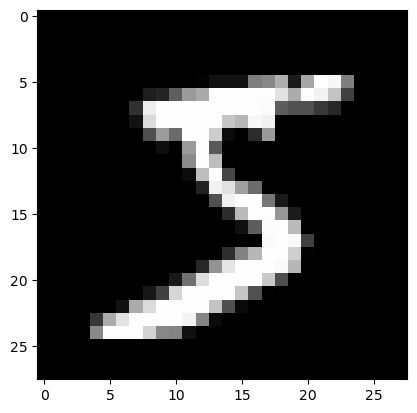

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np

dataset = MNIST(root='MNIST', download=True,transform=transforms.Compose([transforms.ToTensor()]))

import matplotlib.pyplot as plt

plt.imshow(dataset[0][0].squeeze(), cmap='gray')

batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
class ForwardDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor
        
    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
def load_generated_dataset():
    x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('x_0_dataset.pth'), torch.load('t_batch_dataset.pth'), torch.load('suff_stats_dataset.pth')
    return ForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataset = load_generated_dataset()

forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=batch_size, shuffle=True)

## Model

In [6]:
# from models import UNet

In [7]:
import torch.nn.functional as F
from models import UNet
device = 'cuda'
model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

class BetaUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

    def forward(self, suff_stats, t):
        return F.sigmoid(self.model(suff_stats, t))

model = BetaUnet()
model = model.to(device)
model.load_state_dict(torch.load('beta_ddpm_the_best.pth'))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:

train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=40000)


Iter 45 Loss: 0.0010:   0%|                                                  | 46/40000 [00:05<1:21:44,  8.15it/s]


KeyboardInterrupt: 

In [18]:
# torch.save(model.state_dict(), 'beta_ddpm_the_best.pth')

100%|███████████████████████████████████████████████████████████████████████████| 999/999 [00:20<00:00, 49.44it/s]


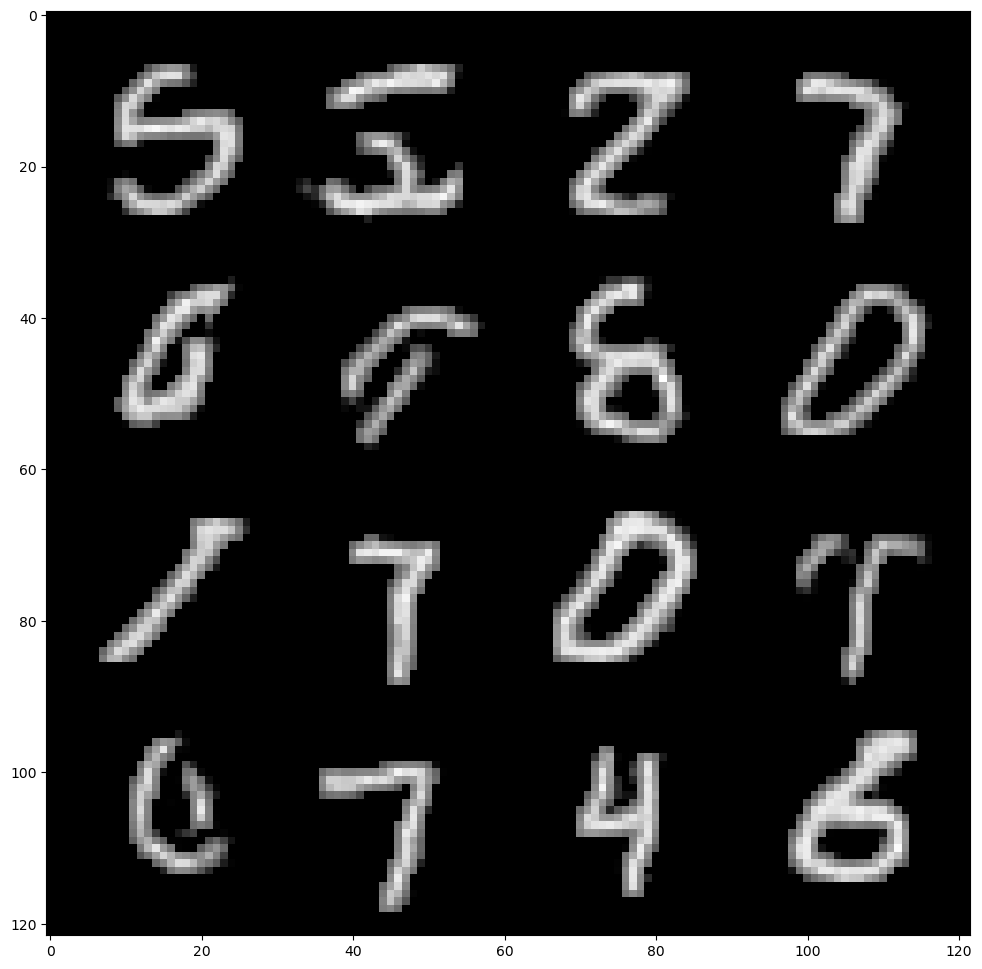

In [12]:
samples, samples_history = generate_alpha_normed(model)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

plt.figure(figsize = (12,12))

img = np.asarray(Image.open('beta_ssddpm_samples.png'))
imgplot = plt.imshow(img, cmap='gray')

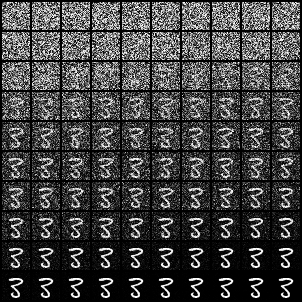

In [10]:

t_batch = torch.tensor([0], device=device).repeat(batch_size)

x_0 = next(iter(dataloader))[0].to(device)
samples, suff_stats_normed = sample_chain_suff_stats_norm_alpha(t_batch, x_0)

img_grid = torchvision.utils.make_grid(torch.cat([item[0] for item in samples[::10]], dim=0).unsqueeze(1) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

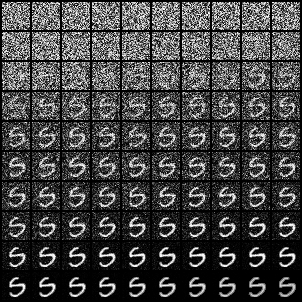

In [13]:
# samples_history[0].shape

img_grid = torchvision.utils.make_grid(torch.cat([item[0] for item in samples_history[::10]], dim=0).unsqueeze(1) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)